<a href="https://colab.research.google.com/github/GreenStreetQuant/TSLA-ARIMA/blob/master/TSLA_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np 
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from google.colab import files
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

In [0]:
uploaded = files.upload()

Saving TSLA.csv to TSLA.csv


In [0]:
tsla_data = pd.read_csv('TSLA.csv')

In [0]:
tsla1 = tsla_data.set_index(pd.DatetimeIndex(tsla_data['Date']))
tsla1.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1509, freq=None)

In [0]:
#Resampling to Monthly average
tsla = tsla1['Close'].resample('MS').mean()
tsla.index.min()

Timestamp('2014-01-01 00:00:00')

Text(0, 0.5, 'Price ($)')

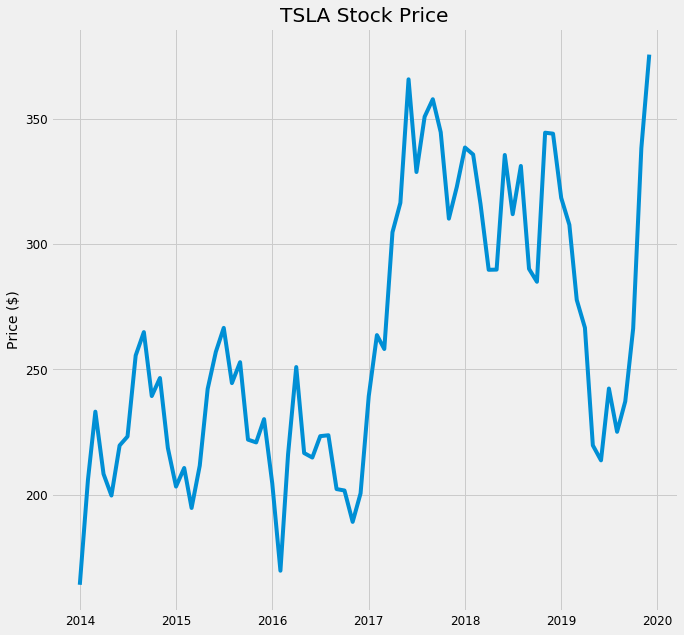

In [0]:
plt.figure(figsize=(10,10))
plt.plot(tsla)
plt.title('TSLA Stock Price')
plt.ylabel('Price ($)')

Most Stocks will be not be stationary given the nature of Stocks being an investment that (ideally) increases over time.. 
But to check we will use Dickey-Fuller Test

In [0]:
def test_stationarity(ts):
  rolmean = ts.rolling(window=12).mean()
  rolstd = ts.rolling(window=12).std()

  plt.figure(figsize=(12,10))
  orig = plt.plot(ts, color='blue', label='Original')
  mean = plt.plot(rolmean, color='r', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)
    
    
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

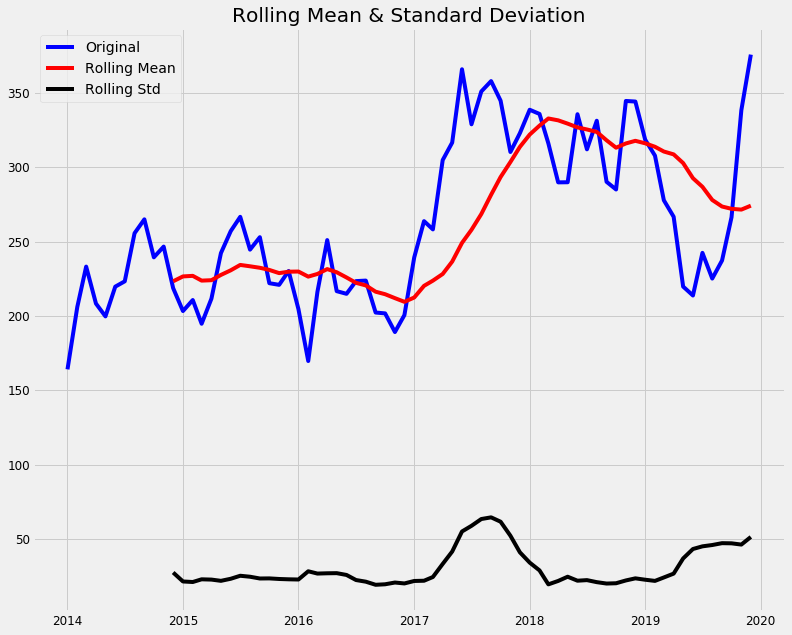

Results of Dickey-Fuller Test:
Test Statistic                 -1.991606
p-value                         0.290265
#Lags Used                      0.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [0]:
test_stationarity(tsla)

Mean is clearly increasing over time and rather large variations in the Standard deviation. Also, a large difference in the test statistic versus the critical values

Using Decomposition breaking out the seasonaility, trend, and noise

In [0]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 16, 8

tsla_decomposition = sm.tsa.seasonal_decompose(tsla, model='additive')
tsla_decomposition1 = sm.tsa.seasonal_decompose(tsla, model='multiplicative')

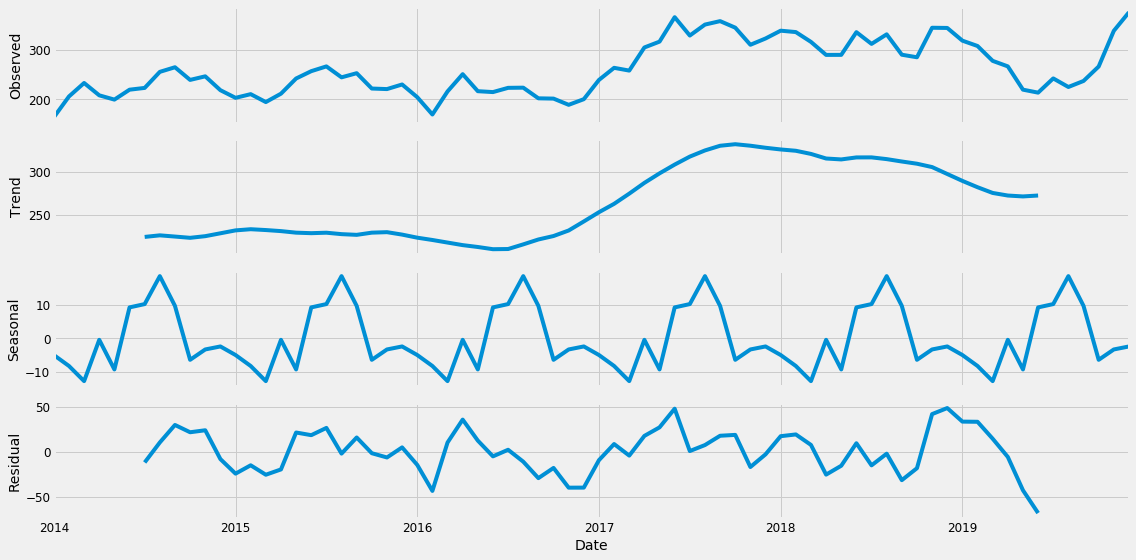

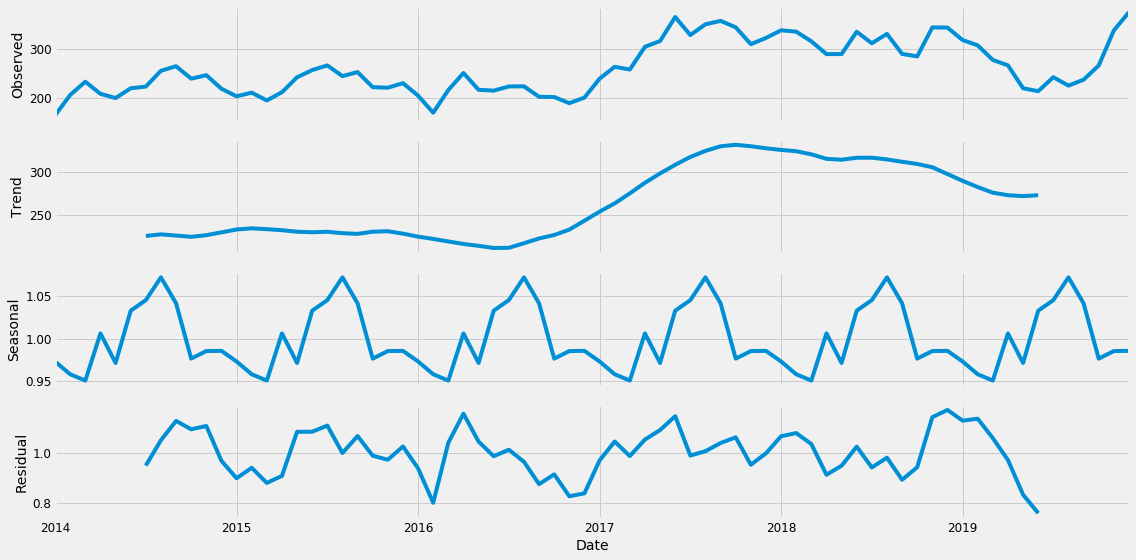

In [0]:
fig = tsla_decomposition.plot()
fig1 = tsla_decomposition1.plot()
plt.show()

Taking the log of the data to see if we can reduce trend..

In [0]:
tsla_log = np.log(tsla)

Text(0.5, 1.0, 'TSLA')

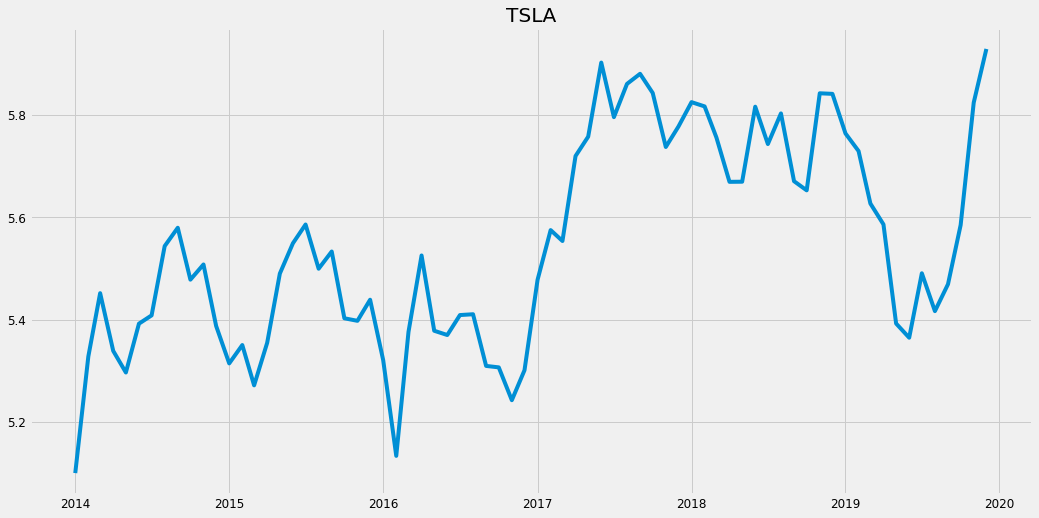

In [0]:
plt.plot(tsla_log)
plt.title('TSLA')

In [0]:
moving_avg_tsla = tsla_log.rolling(window=6).mean()

Text(0.5, 1.0, 'TSLA')

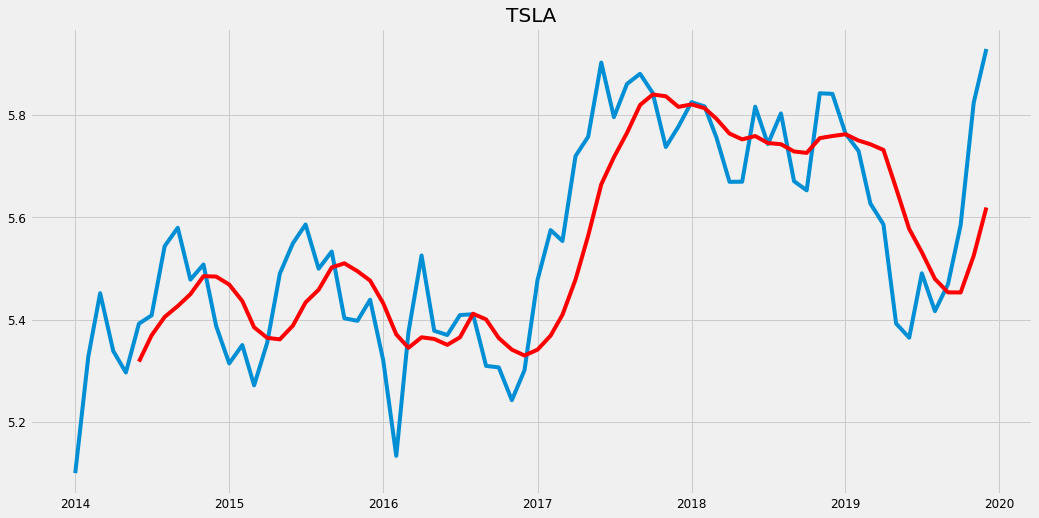

In [0]:
plt.plot(tsla_log)
plt.plot(moving_avg_tsla, 'r')
plt.title('TSLA')

Checking ACF

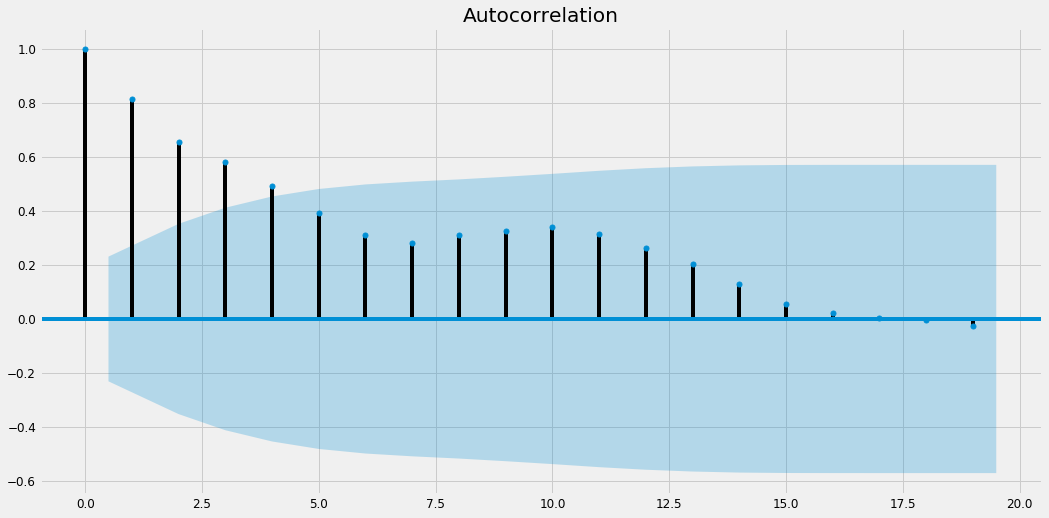

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(tsla_log)
plt.show()

In [0]:
tsla_log_mavg_diff = tsla_log - moving_avg_tsla

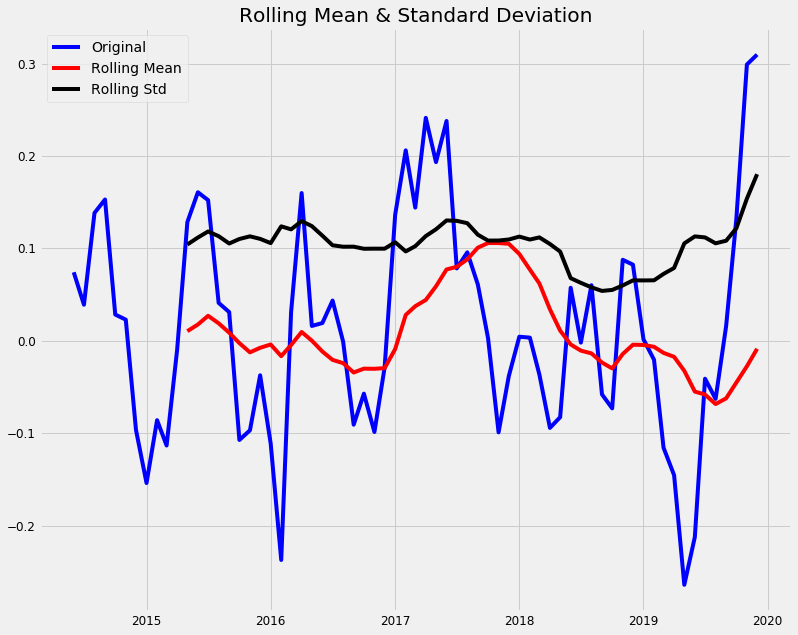

Results of Dickey-Fuller Test:
Test Statistic                 -4.227101
p-value                         0.000593
#Lags Used                      4.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [0]:
tsla_log_mavg_diff.dropna(inplace=True)
test_stationarity(tsla_log_mavg_diff)

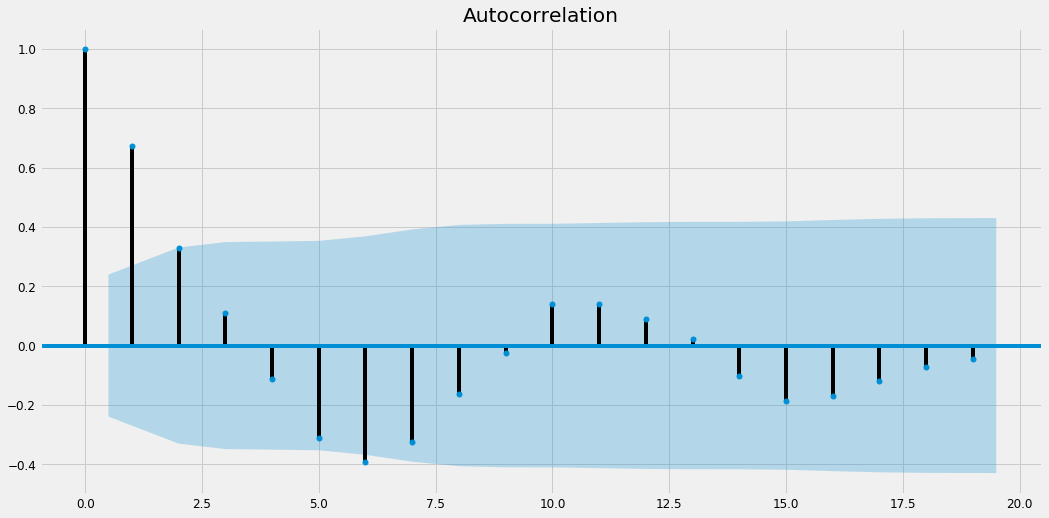

In [0]:
plot_acf(tsla_log_mavg_diff)
plt.show()

Text(0.5, 1.0, 'TSLA')

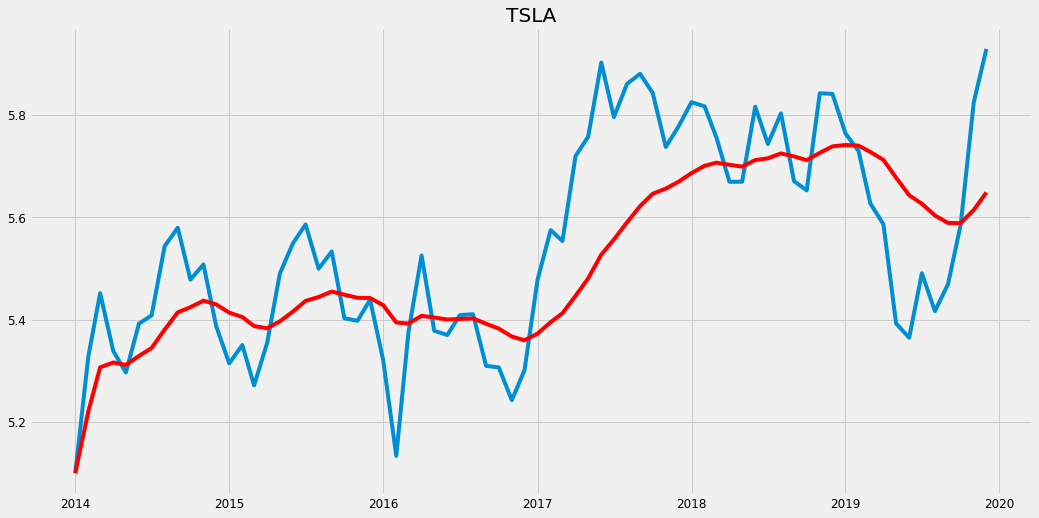

In [0]:
expweighte_avg_tsla = tsla_log.ewm(halflife=6).mean()
plt.plot(tsla_log)
plt.plot(expweighte_avg_tsla, 'r')
plt.title('TSLA')

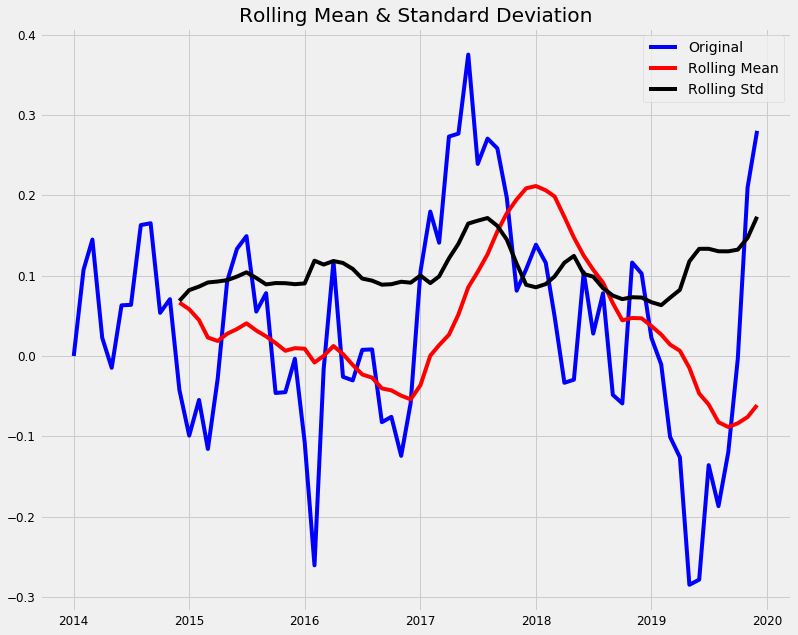

Results of Dickey-Fuller Test:
Test Statistic                 -2.734873
p-value                         0.068196
#Lags Used                      0.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [0]:
tsla_log_ewm_diff = tsla_log - expweighte_avg_tsla
test_stationarity(tsla_log_ewm_diff)

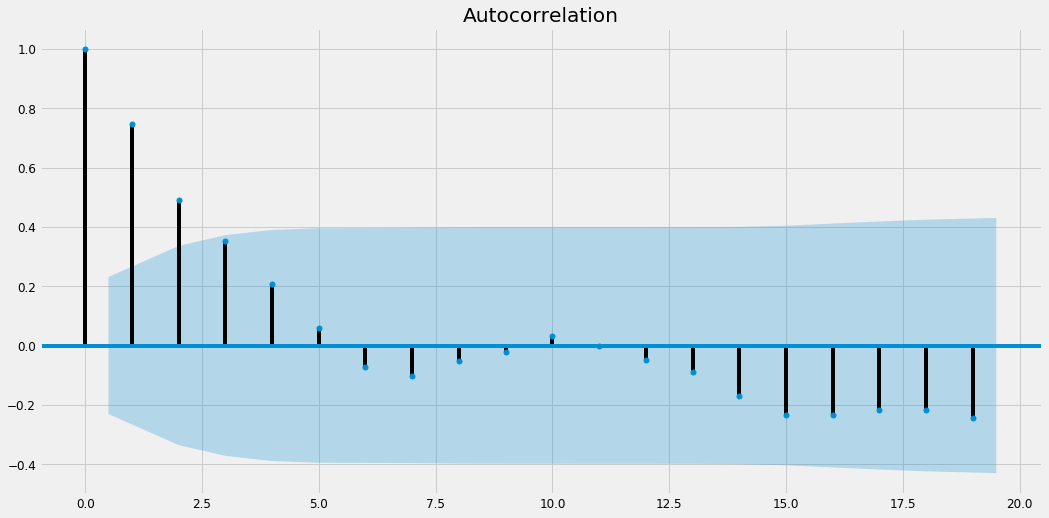

In [0]:
plot_acf(tsla_log_ewm_diff)
plt.show()

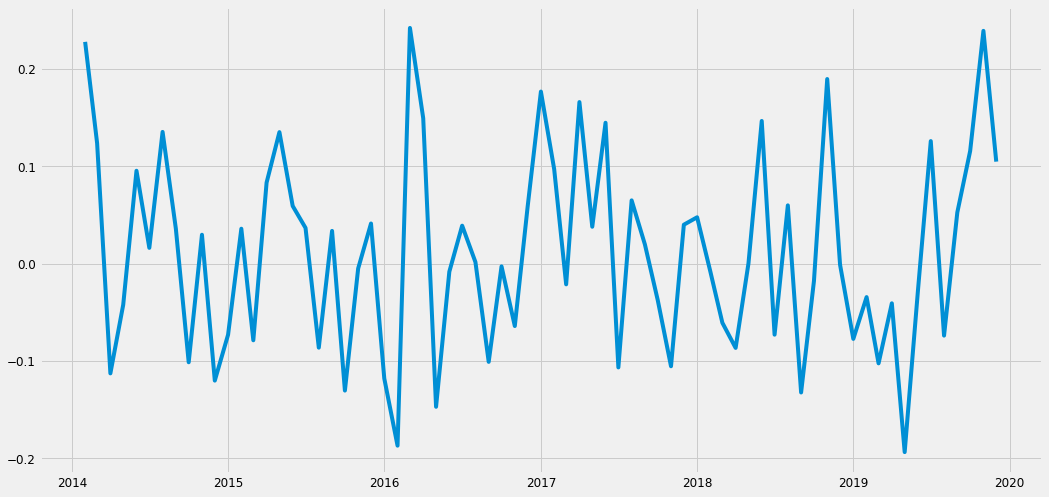

In [0]:
tsla_log_diff = tsla_log - tsla_log.shift()
plt.plot(tsla_log_diff)

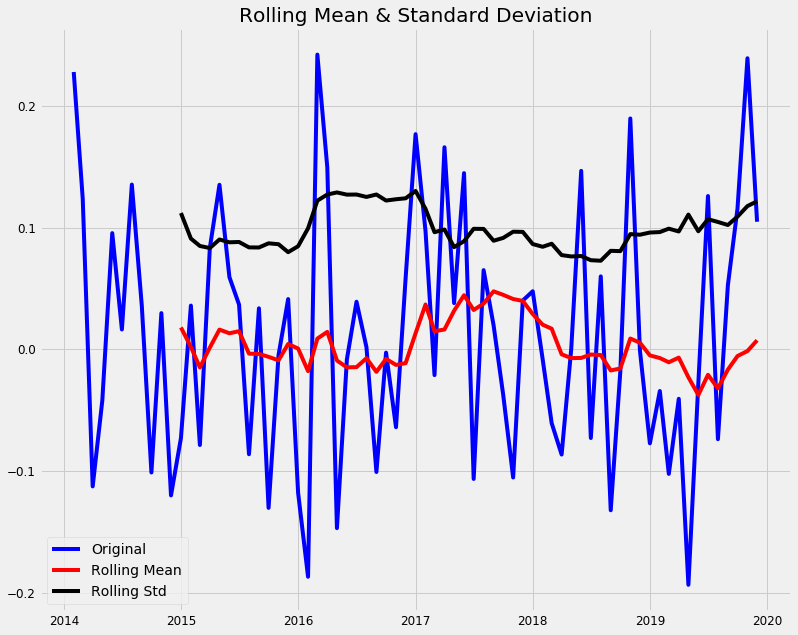

Results of Dickey-Fuller Test:
Test Statistic                -7.816865e+00
p-value                        6.833190e-12
#Lags Used                     0.000000e+00
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [0]:
tsla_log_diff.dropna(inplace=True)
test_stationarity(tsla_log_diff)

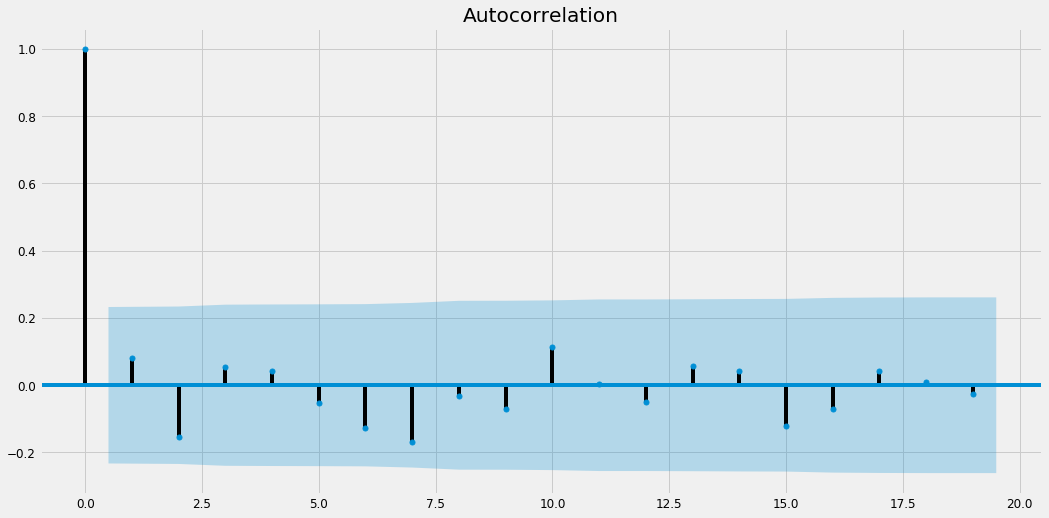

In [0]:
plot_acf(tsla_log_diff)
plt.show()

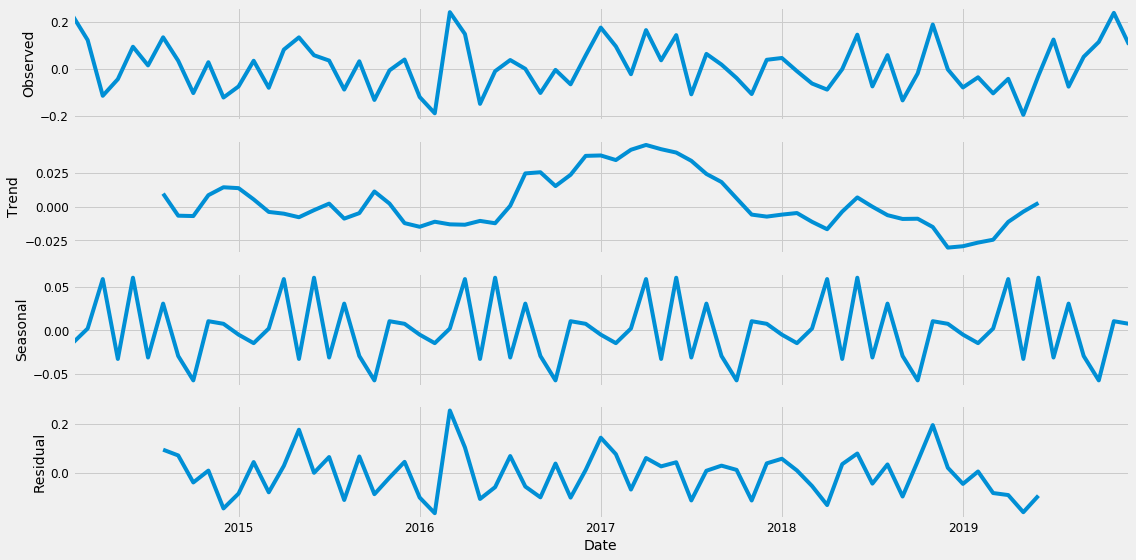

In [0]:
tsla_decomposition_log_dif = sm.tsa.seasonal_decompose(tsla_log_diff, model='additive')

fig2 = tsla_decomposition_log_dif.plot()
plt.show()

In [0]:
from statsmodels.tsa.arima_model import ARIMA

Finding best parameters for ARIMA model using Grid Search

In [0]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(
          tsla_log,
          order=param,
          seasonal_order=param_seasonal,
          enforce_stationarity=False,
          enforce_invertibility=False,
          enforce_differencing=False
      )
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:446.97072177051746
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:325.0922192820516
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.693918637786542
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8.82874240425314
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3.2884433850444608
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-9.669316450755275
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10.162189456742578
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12.263684791340022
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:351.3437479041825
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:245.93136791482624
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-39.320247219715135
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-28.27444735937246
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-39.745499457707844


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-34.483494110076364
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-25.989865121748963
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-23.4313318795646
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-120.98764369623306
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-95.16229928416898
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-56.625289473315746
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-60.117261892142054
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-97.71348169115622
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-93.23389416546942
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-49.143329386173065
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-53.60972185334644
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-118.02175551379659
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-91.52895466489139
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-55.125702032778264
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-59.96274766525272
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-96.25448093574124
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-92.7402732570804
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-47.1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-94.34261804293145
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-50.4280366512229
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-52.701086640939195
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-117.64077928512305


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-91.57279406525387
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-58.51962228669855


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-59.19328328183322
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-94.77129388482481
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-72.40984132505284
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-49.167779289556975
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-53.635813294727754
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-119.55989271325495
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-93.58094366375842
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-54.67719173807849


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-57.67225726326647
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-93.65862659818856
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-94.17200273528121
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-50.01488511583801
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-52.15187799132402
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-116.33871421496494
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-89.94932506502929
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-53.64998153882663
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-58.48682017100282
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-92.36745784175304
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-92.12229205418426
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-48.99470022826051
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-54.026060112077644


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-119.55989271325495

Yields the Lowest AIC, we will use that

In [0]:
mod = sm.tsa.statespace.SARIMAX(tsla_log,
                                order=(1, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0877      0.113      0.776      0.438      -0.134       0.309
sigma2         0.0100      0.002      5.200      0.000       0.006       0.014


Validating the forecast against original values

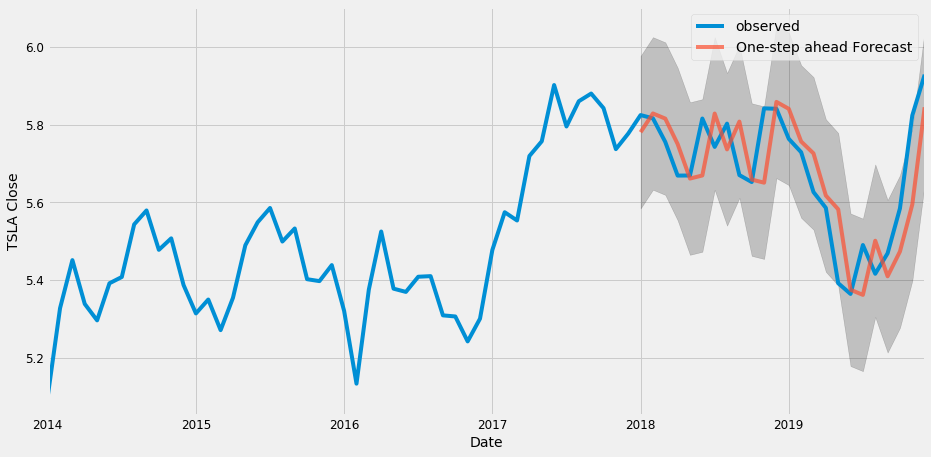

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = tsla_log['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('TSLA Close')
plt.legend()
plt.show()

In [0]:
y_forecasted = pred.predicted_mean 
y_truth = tsla_log['2018-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecast is {mse}')

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecast is 0.010594310996053227
The Root Mean Squared Error of our forecasts is 0.1


Taking it back to original scale

In [0]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2014-01-01    0.000000
2014-02-01    5.323900
2014-03-01    5.347974
2014-04-01    5.462518
2014-05-01    5.329029
Freq: MS, dtype: float64

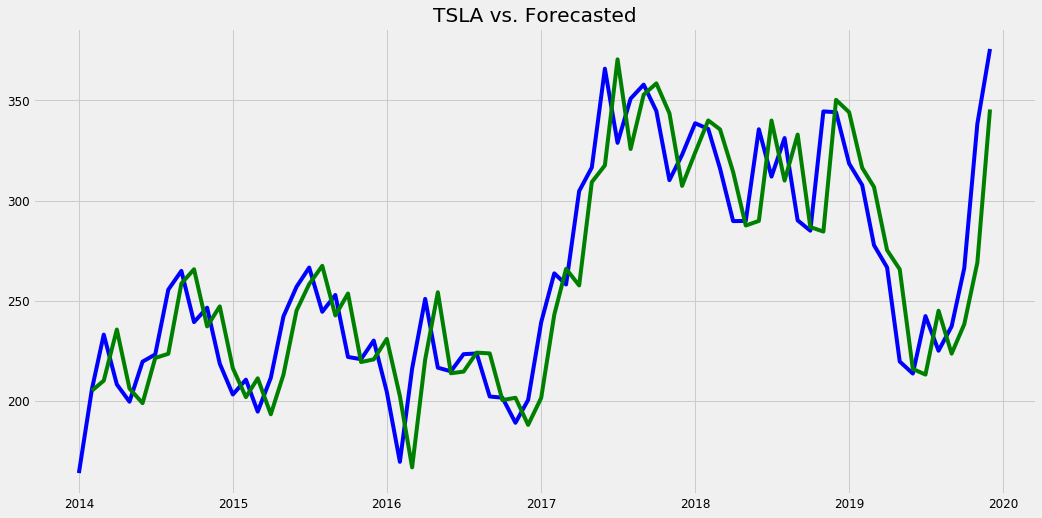

In [0]:
plt.figure(figsize=(16,8))
predictions_ARIMA = np.exp(predictions_ARIMA_diff)
predictions_ARIMA = predictions_ARIMA['2014-02-01':]
plt.plot(tsla, 'b')
plt.plot(predictions_ARIMA, 'g')
plt.title('TSLA vs. Forecasted')
plt.show()

In [0]:
pred2 = results.get_prediction(start=pd.to_datetime('2014-02-01'), dynamic=False)
y_forecasted = pred2.predicted_mean 
y_forecasted_exp = np.exp(y_forecasted)
y_truth = tsla['2014-02-01':]

mse = ((y_forecasted_exp - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecast is {mse}')

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecast is 670.0600803590561
The Root Mean Squared Error of our forecasts is 25.89
